## Description
In 2013, we hosted one of our favorite for-fun competitions:  Dogs vs. Cats. Much has since changed in the machine learning landscape, particularly in deep learning and image analysis. Back then, a tensor flow was the diffusion of the creamer in a bored mathematician's cup of coffee. Now, even the cucumber farmers are neural netting their way to a bounty.

## Dataset
The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id. For each image in the test set, you should predict a probability that the image is a dog (1 = dog, 0 = cat).

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
import torchvision.models as models
import timm
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Data Preparation

1. Download dataseet from kaggle competition that contain images of dogs and cats.
2. This code initializes the process of preparing an image dataset for training an AI model.
3. The dataset, located in the "data/train" directory, is loaded using PyTorch's torchvision library
4. Image transformations, including resizing, flipping, and rotation, are applied to augment the dataset and improve model robustness.
6. The dataset is split into training (80%) and validation (20%) sets to facilitate effective model training and evaluation
7. These meticulous preparations pave the way for building a powerful image classification model, offering business users the potential for accurate and insightful analyses based on visual data.

In [3]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(15),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = torchvision.datasets.ImageFolder(root="data/train", transform=transforms)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [
    int(len(dataset)*0.8),
    len(dataset)-int(len(dataset)*0.8)
])

In [4]:
print(dataset.class_to_idx)
print(dataset.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


## Step 2 : Design Model - Resnet18

Using pretrained resnet18 model provided from pytorch, and customize the output layer with size 2 instead of 1000

The model is based on ResNet18, a powerful pre-trained neural network for image classification.
Customization involves adjusting the output layer to suit a binary classification task (distinguishing between two classes, e.g., cats and dogs).
This modification allows the model to leverage the knowledge gained from a large dataset while tailoring it to specific business needs.

In [5]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=True)
        self.resnet.fc = nn.Linear(512, 2)

    def forward(self, x):
        return self.resnet(x)

## Step 3 : Model Training - ResNet
- Training occurs over 10 epochs, where each epoch represents a full pass through the dataset.
- Utilizes a batch size of 64 for efficiency.
- Optimized using the Adam optimizer with a learning rate of (0.001). 
- The training process involves iterating through the training dataset, adjusting the model's parameters based on the error (loss), and validating the model's performance on a separate dataset*


This implementation involves designing and training a ResNet18-based neural network for image classification, tailored to a binary task such as distinguishing between cats and dogs. Leveraging a pre-trained model ensures a strong foundation, while customizing the output layer optimizes it for specific business requirements. The training process spans 10 epochs, refining the model's accuracy and efficiency through iterative adjustments. Key metrics, including accuracy and loss, are tracked, allowing for performance insights and ensuring the preservation of the best-performing model. This tailored approach ensures that the model not only benefits from broad knowledge but also aligns closely with the nuances of the business problem at hand, potentially finding applications in various domains such as quality control or content categorization.

In [6]:
device = "cuda"
n_epochs = 10
batch_size = 64

lr = 0.001

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)

In [8]:
model = Net()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [9]:
best_valid_loss = 10000

for epoch in range(n_epochs):
    train_accs = []
    train_losses = []
    valid_accs = []
    valid_losses = []
    
    # Train loop
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.cpu().argmax(dim=1) == target.cpu()).sum().item() / len(target)
        train_accs.append(acc)
        train_losses.append(loss.item())

    # Validation loop
    model.eval()
    for idx, (data, target) in enumerate(valid_loader):
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
            
        acc = (output.cpu().argmax(dim=1) == target.cpu()).sum().item() / len(target)
        valid_accs.append(acc)
        valid_losses.append(loss.item())

    if best_valid_loss > sum(valid_losses)/len(valid_accs):
        best_valid_loss = sum(valid_losses)/len(valid_accs)
        torch.save({'model_state_dict': model.state_dict() }, '/tmp/model.pt')
        print("Save the model checkpoint")
        
    # Logging
    print((
        f"Epoch {epoch}/{n_epochs}: "
        f"Train accuray={sum(train_accs)/len(train_accs):.6f}, Train Loss={sum(train_losses)/len(train_accs):.6f} "
        f"Valid accuray={sum(valid_accs)/len(valid_accs):.6f}, Valid Loss={sum(valid_losses)/len(valid_accs):.6f}"
    ))

Save the model checkpoint
Epoch 0/10: Train accuray=0.938748, Train Loss=0.151108 Valid accuray=0.935522, Valid Loss=0.165872
Save the model checkpoint
Epoch 1/10: Train accuray=0.956070, Train Loss=0.106617 Valid accuray=0.944027, Valid Loss=0.136651
Save the model checkpoint
Epoch 2/10: Train accuray=0.963458, Train Loss=0.091406 Valid accuray=0.950554, Valid Loss=0.124657
Save the model checkpoint
Epoch 3/10: Train accuray=0.967153, Train Loss=0.083749 Valid accuray=0.968948, Valid Loss=0.084491
Epoch 4/10: Train accuray=0.971645, Train Loss=0.069827 Valid accuray=0.954905, Valid Loss=0.119267
Epoch 5/10: Train accuray=0.973343, Train Loss=0.065251 Valid accuray=0.965190, Valid Loss=0.106206
Save the model checkpoint
Epoch 6/10: Train accuray=0.974840, Train Loss=0.062708 Valid accuray=0.970332, Valid Loss=0.080083
Epoch 7/10: Train accuray=0.980581, Train Loss=0.052401 Valid accuray=0.962223, Valid Loss=0.114092
Epoch 8/10: Train accuray=0.975639, Train Loss=0.062047 Valid accuray=

## Step 4: Model inference on test dataset
-  Model Loading: A trained neural network (model) is loaded for making predictions on new, unseen data.
-  Data Transformation: Test images are transformed to ensure consistency with the training data, including resizing and normalization.
-  Inference Process: The model processes each image from the test dataset individually, predicting the likelihood of belonging to the positive class(e.g., a specific category, object, or feature).
-  Results Collection: The predicted probabilities are collected for each image, providing insights into the model's confidence in its predictions.

In [10]:
model = Net()

checkpoint = torch.load('/tmp/model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)

In [11]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
import os
import os.path as osp
from PIL import Image

TEST_DIR = "data/test/unknown/"
paths = os.listdir(TEST_DIR)
paths = sorted(paths, key=lambda name: int(name.split('/')[-1].split('.')[0]))

answers = []
for fname in paths:
    img = Image.open(osp.join(TEST_DIR, fname))
    data = transforms(img)
    data = data.unsqueeze(0)
    data = data.to(device)

    output = model(data)
    prob = F.softmax(output, dim=1)[:, 1]
    answers.append(prob.item())

In [13]:
df = pd.DataFrame({
    'id': [ i+1 for i in range(len(answers)) ],
    'label': answers
})
df.to_csv('test.csv', index=None)

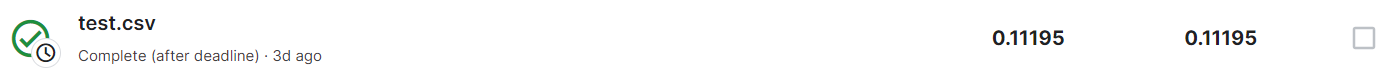

## Below section I implement similar procee using different models and hyper parameter and evaluate the performance on kaggle

### Xception - Different transform agument, batch normalization, early stopping

In [4]:
input_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms_xception = v2.Compose([
        v2.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize(mean, std)
])

In [5]:
dataset = torchvision.datasets.ImageFolder(root="data/train", transform=transforms_xception)
train_dataset_xception, valid_dataset_xception = torch.utils.data.random_split(dataset, [
    int(len(dataset)*0.8),
    len(dataset)-int(len(dataset)*0.8)
])

In [6]:
class XceptionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.xception = models.xception(pretrained=True)
        for param in self.xception.parameters():
            param.requires_grad = False
        self.xception.fc = nn.Linear(2048, 2)
        self.batch_norm = nn.BatchNorm1d(2)

    def forward(self, x):
        x = self.xception(x)
        x = self.batch_norm(x)
        return x

In [7]:
device = "cuda"
n_epochs = 5
batch_size = 64
lr = 0.001
train_loader_xception = DataLoader(train_dataset_xception, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader_xception = DataLoader(valid_dataset_xception, batch_size=batch_size, num_workers=8)

In [8]:
model_xception = timm.create_model('xception', pretrained=True)
model_xception = model_xception.to(device)
params_to_update = model_xception.parameters()
optimizer_xception = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer_xception, mode='min', factor=0.1, patience=3, verbose=True)
criterion_xception = nn.CrossEntropyLoss()

/home/johnnylord/.pyenv/versions/pytorch/lib/python3.8/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [9]:
# Early Stopping parameters
patience = 5
early_stop_counter = 0
best_valid_loss_xception = float('inf')

for epoch in range(n_epochs):
    train_accs_xception = []
    train_losses_xception = []
    valid_accs_xception = []
    valid_losses_xception = []

    # Train loop
    model_xception.train()
    for idx, (data, target) in enumerate(train_loader_xception):
        data = data.to(device)
        target = target.to(device)

        output = model_xception(data)
        loss = criterion_xception(output, target)

        optimizer_xception.zero_grad()
        loss.backward()
        optimizer_xception.step()

        acc = (output.cpu().argmax(dim=1) == target.cpu()).sum().item() / len(target)
        train_accs_xception.append(acc)
        train_losses_xception.append(loss.item())

    # Validation loop
    model_xception.eval()
    for idx, (data, target) in enumerate(valid_loader_xception):
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            output = model_xception(data)
            loss = criterion_xception(output, target)

        acc = (output.cpu().argmax(dim=1) == target.cpu()).sum().item() / len(target)
        valid_accs_xception.append(acc)
        valid_losses_xception.append(loss.item())

    # Calculate average losses and accuracies
    avg_train_loss = sum(train_losses_xception) / len(train_accs_xception)
    avg_valid_loss = sum(valid_losses_xception) / len(valid_accs_xception)
    avg_train_acc = sum(train_accs_xception) / len(train_accs_xception)
    avg_valid_acc = sum(valid_accs_xception) / len(valid_accs_xception)

    print((
        f"Epoch {epoch+1}/{n_epochs}: "
        f"Train accuracy={avg_train_acc:.6f}, Train Loss={avg_train_loss:.6f} "
        f"Valid accuracy={avg_valid_acc:.6f}, Valid Loss={avg_valid_loss:.6f}"
    ))

    # Check for early stopping
    if avg_valid_loss < best_valid_loss_xception:
        best_valid_loss_xception = avg_valid_loss
        early_stop_counter = 0
        torch.save({'model_state_dict': model_xception.state_dict()}, '/tmp/model_xception.pt')
        print("Save the Xception model checkpoint")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping after {patience} epochs of no improvement.")
            break

    # Learning rate scheduler step
    scheduler.step(avg_valid_loss)

Epoch 1/5: Train accuracy=0.855232, Train Loss=0.943132 Valid accuracy=0.977057, Valid Loss=0.082771
Save the Xception model checkpoint
Epoch 2/5: Train accuracy=0.976238, Train Loss=0.073013 Valid accuracy=0.981804, Valid Loss=0.053266
Save the Xception model checkpoint
Epoch 3/5: Train accuracy=0.981280, Train Loss=0.054528 Valid accuracy=0.985562, Valid Loss=0.042203
Save the Xception model checkpoint
Epoch 4/5: Train accuracy=0.984325, Train Loss=0.045351 Valid accuracy=0.987737, Valid Loss=0.036860
Save the Xception model checkpoint
Epoch 5/5: Train accuracy=0.985573, Train Loss=0.039281 Valid accuracy=0.986353, Valid Loss=0.037098


In [10]:
model_xception = timm.create_model('xception', pretrained=True)
checkpoint_xception = torch.load('/tmp/model_xception.pt')
model_xception.load_state_dict(checkpoint_xception['model_state_dict'])
model_xception = model_xception.to(device)

transforms_xception_test = v2.Compose([
        v2.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize(mean, std)
])


In [11]:
import os
TEST_DIR_XCEPTION = "data/test/unknown/"
paths_xception = os.listdir(TEST_DIR_XCEPTION)
paths_xception = sorted(paths_xception, key=lambda name: int(name.split('/')[-1].split('.')[0]))

answers_xception = []
for fname_xception in paths_xception:
    img_xception = Image.open(os.path.join(TEST_DIR_XCEPTION, fname_xception))
    data_xception = transforms_xception_test(img_xception)
    data_xception = data_xception.unsqueeze(0)
    data_xception = data_xception.to(device)

    output_xception = model_xception(data_xception)
    prob_xception = F.softmax(output_xception, dim=1)[:, 1]
    answers_xception.append(prob_xception.item())

In [12]:
df_xception = pd.DataFrame({
    'id': [i+1 for i in range(len(answers_xception))],
    'label': answers_xception
})
df_xception.to_csv('test_batch_xception.csv', index=None)

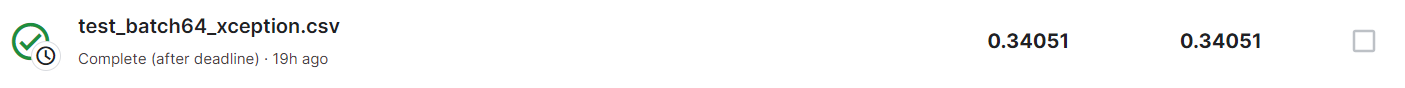

### VGG 16 - First Attempt

In [2]:
transforms_vgg = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/home/johnnylord/.pyenv/versions/pytorch/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [13]:
dataset_vgg = torchvision.datasets.ImageFolder(root="data/train", transform=transforms_vgg)
train_dataset_vgg, valid_dataset_vgg = torch.utils.data.random_split(dataset_vgg, [
    int(len(dataset_vgg) * 0.8),
    len(dataset_vgg) - int(len(dataset_vgg) * 0.8)
])

print(dataset_vgg.class_to_idx)
print(dataset_vgg.classes)
print(len(train_dataset_vgg))
print(len(valid_dataset_vgg))

{'cat': 0, 'dog': 1}
['cat', 'dog']
20000
5000


In [4]:
class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg.classifier[6] = nn.Linear(4096, 2)

    def forward(self, x):
        return self.vgg(x)

In [5]:
device = "cuda"
n_epochs = 10
batch_size = 64
lr = 0.001
train_loader_vgg = DataLoader(train_dataset_vgg, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader_vgg = DataLoader(valid_dataset_vgg, batch_size=batch_size, num_workers=8)
model_vgg = VGGNet()
model_vgg = model_vgg.to(device)
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=lr)
criterion_vgg = nn.CrossEntropyLoss()
best_valid_loss_vgg = 10000

/home/johnnylord/.pyenv/versions/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/johnnylord/.pyenv/versions/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Model on test dataset
model_vgg = VGGNet()
checkpoint_vgg = torch.load('/tmp/model_vgg.pt')
model_vgg.load_state_dict(checkpoint_vgg['model_state_dict'])
model_vgg = model_vgg.to(device)

transforms_vgg_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
for epoch in range(n_epochs):
    train_accs_vgg = []
    train_losses_vgg = []
    valid_accs_vgg = []
    valid_losses_vgg = []

    # Train loop
    model_vgg.train()
    for idx, (data, target) in enumerate(train_loader_vgg):
        data = data.to(device)
        target = target.to(device)

        output = model_vgg(data)
        loss = criterion_vgg(output, target)

        optimizer_vgg.zero_grad()
        loss.backward()
        optimizer_vgg.step()

        acc = (output.cpu().argmax(dim=1) == target.cpu()).sum().item() / len(target)
        train_accs_vgg.append(acc)
        train_losses_vgg.append(loss.item())

    # Validation loop
    model_vgg.eval()
    for idx, (data, target) in enumerate(valid_loader_vgg):
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            output = model_vgg(data)
            loss = criterion_vgg(output, target)

        acc = (output.cpu().argmax(dim=1) == target.cpu()).sum().item() / len(target)
        valid_accs_vgg.append(acc)
        valid_losses_vgg.append(loss.item())

    if best_valid_loss_vgg > sum(valid_losses_vgg) / len(valid_accs_vgg):
        best_valid_loss_vgg = sum(valid_losses_vgg) / len(valid_accs_vgg)
        torch.save({'model_state_dict': model_vgg.state_dict()}, '/tmp/model_vgg.pt')
        print("Save the VGG model checkpoint")

    # Logging
    print((
        f"Epoch {epoch}/{n_epochs}: "
        f"Train accuracy={sum(train_accs_vgg) / len(train_accs_vgg):.6f}, Train Loss={sum(train_losses_vgg) / len(train_accs_vgg):.6f} "
        f"Valid accuracy={sum(valid_accs_vgg) / len(valid_accs_vgg):.6f}, Valid Loss={sum(valid_losses_vgg) / len(valid_accs_vgg):.6f}"
    ))

Save the VGG model checkpoint
Epoch 0/10: Train accuracy=0.562300, Train Loss=0.725352 Valid accuracy=0.496242, Valid Loss=0.694544
Save the VGG model checkpoint
Epoch 1/10: Train accuracy=0.518670, Train Loss=0.693161 Valid accuracy=0.571005, Valid Loss=0.676225
Epoch 2/10: Train accuracy=0.513279, Train Loss=0.722600 Valid accuracy=0.496242, Valid Loss=0.694417
Epoch 3/10: Train accuracy=0.498153, Train Loss=0.693943 Valid accuracy=0.496242, Valid Loss=0.693248
Epoch 4/10: Train accuracy=0.498003, Train Loss=0.694892 Valid accuracy=0.496242, Valid Loss=0.700666
Epoch 5/10: Train accuracy=0.491663, Train Loss=0.694706 Valid accuracy=0.496242, Valid Loss=0.693238
Epoch 6/10: Train accuracy=0.494958, Train Loss=0.694055 Valid accuracy=0.496242, Valid Loss=0.693199
Epoch 7/10: Train accuracy=0.495857, Train Loss=0.694281 Valid accuracy=0.503758, Valid Loss=0.693704
Epoch 8/10: Train accuracy=0.500399, Train Loss=0.693856 Valid accuracy=0.496242, Valid Loss=0.693188
Epoch 9/10: Train accu

In [9]:
import os
TEST_DIR_VGG = "data/test/unknown/"
paths_vgg = os.listdir(TEST_DIR_VGG)
paths_vgg = sorted(paths_vgg, key=lambda name: int(name.split('/')[-1].split('.')[0]))

answers_vgg = []
for fname_vgg in paths_vgg:
    img_vgg = Image.open(os.path.join(TEST_DIR_VGG, fname_vgg))
    data_vgg = transforms_vgg_test(img_vgg)
    data_vgg = data_vgg.unsqueeze(0)
    data_vgg = data_vgg.to(device)

    output_vgg = model_vgg(data_vgg)
    prob_vgg = F.softmax(output_vgg, dim=1)[:, 1]
    answers_vgg.append(prob_vgg.item())

In [10]:
df_vgg = pd.DataFrame({
    'id': [i + 1 for i in range(flen(answers_vgg))],
    'label': answers_vgg
})
df_vgg.to_csv('test_batch64_vgg.csv', index=None)

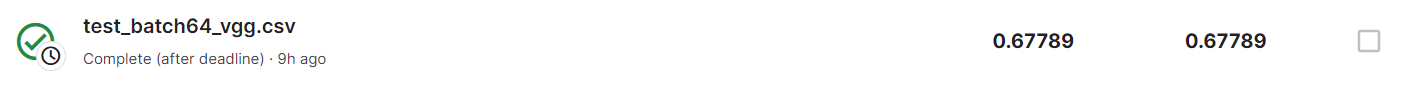

### Vgg16 - Second Attempt
Try out different data transformation and optimizer (use optim.SGD) and batch_size = 32

In [10]:
input_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms_vgg = v2.Compose([
        v2.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize(mean, std)
])

In [11]:
dataset_vgg = torchvision.datasets.ImageFolder(root="data/train", transform=transforms_vgg)
train_dataset_vgg, valid_dataset_vgg = torch.utils.data.random_split(dataset_vgg, [
    int(len(dataset_vgg) * 0.8),
    len(dataset_vgg) - int(len(dataset_vgg) * 0.8)
])

print(dataset_vgg.class_to_idx)
print(dataset_vgg.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset_vgg, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset_vgg, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': valid_loader}

In [15]:
batch_size =32
num_epochs =5
feature_extract = True
num_classes = 2
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)

/home/johnnylord/.pyenv/versions/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/johnnylord/.pyenv/versions/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model_ft = model_ft.to(device)

In [20]:
params_to_update = model_ft.parameters()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

- This train_model function comes from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [28]:
import copy
from tqdm.notebook import tqdm
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):

    history = {'accuracy': [],
               'val_accuracy': [],
               'loss': [],
               'val_loss': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['accuracy'].append(epoch_acc.item())
                history['loss'].append(epoch_loss)
            else:
                history['val_accuracy'].append(epoch_acc.item())
                history['val_loss'].append(epoch_loss) 

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [29]:
# setup loss function
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0498 Acc: 0.9811


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0337 Acc: 0.9866

Epoch 1/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0294 Acc: 0.9889


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0329 Acc: 0.9872

Epoch 2/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0223 Acc: 0.9917


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0278 Acc: 0.9894

Epoch 3/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0206 Acc: 0.9924


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0273 Acc: 0.9898

Epoch 4/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0177 Acc: 0.9937


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0254 Acc: 0.9908

Epoch 5/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0156 Acc: 0.9947


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0326 Acc: 0.9892

Epoch 6/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0116 Acc: 0.9961


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0374 Acc: 0.9882

Epoch 7/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0137 Acc: 0.9954


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0311 Acc: 0.9888

Epoch 8/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0128 Acc: 0.9951


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0350 Acc: 0.9866

Epoch 9/9
----------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.0117 Acc: 0.9955


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.0421 Acc: 0.9862

Best val Acc: 0.990800


In [40]:
model_vgg = model_ft
model_vgg = model_vgg.to(device)
model_vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
transforms_vgg_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [42]:
import os
TEST_DIR_VGG = "data/test/unknown/"
paths_vgg = os.listdir(TEST_DIR_VGG)
paths_vgg = sorted(paths_vgg, key=lambda name: int(name.split('/')[-1].split('.')[0]))

answers_vgg = []
for fname_vgg in paths_vgg:
    img_vgg = Image.open(os.path.join(TEST_DIR_VGG, fname_vgg))
    data_vgg = transforms_vgg_test(img_vgg)
    data_vgg = data_vgg.unsqueeze(0)
    data_vgg = data_vgg.to(device)

    output_vgg = model_vgg(data_vgg)
    prob_vgg = F.softmax(output_vgg, dim=1)[:, 1]
    answers_vgg.append(prob_vgg.item())

In [43]:
df_vgg = pd.DataFrame({
    'id': [i + 1 for i in range(len(answers_vgg))],
    'label': answers_vgg
})
df_vgg.to_csv('test_vgg_1.csv', index=None)

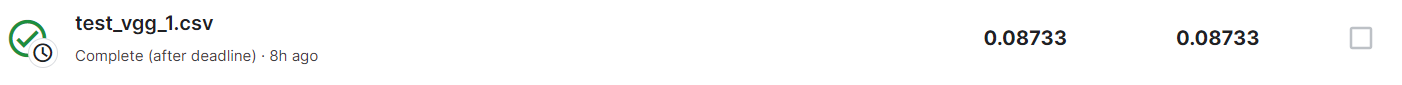

##　Business Impact:

The resulting model is designed to accurately classify images, offering potential applications in scenarios like quality control, security, or content categorization.
The iterative training process ensures continual improvement, aligning the model more closely with the specific nuances of the business problem it aims to solve.